# xESMF Quick Start

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import xesmf as xe

## Regrid 2D data

### Create source grid

A grid is simply an xarray DataSet containing cell centers and bounds. 

Currently look for variable names 'lon', 'lat', 'lon_b', 'lat_b'. Cell centers are alway needed but cell bounds are optional (only for conservative regridding)

In [2]:
# 5 degree in longitude and 4 degree in latitude.
ds_in = xe.grid_global(5, 4)
ds_in

<xarray.Dataset>
Dimensions:  (x: 72, x_b: 73, y: 45, y_b: 46)
Coordinates:
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 ...
    lat      (y, x) float64 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 ...
    lon_b    (y_b, x_b) int64 -180 -175 -170 -165 -160 -155 -150 -145 -140 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

Note: xESMF currently expects coordinates to be 2D arrays, because that's easier for tracking dimensions. Use np.meshgrid( ) to convert 1D lat&lon arrays to 2D orthogonal grids. (Non-orthogonal grids will already be 2D arrays and will just work.)

### Make artificial data on the source grid

In [3]:
def sph_harmonic(lat, lon):
    '''
    spherical harmonic
    '''
    # degree to radias
    lat = lat/180.0*np.pi
    lon = lon/180.0*np.pi
    f = 2 + np.sin(2*lat)**2 * np.cos(8*lon)
    return f

ds_in['data'] = sph_harmonic(ds_in['lat'],ds_in['lon'])
ds_in

<xarray.Dataset>
Dimensions:  (x: 72, x_b: 73, y: 45, y_b: 46)
Coordinates:
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 ...
    lat      (y, x) float64 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 ...
    lon_b    (y_b, x_b) int64 -180 -175 -170 -165 -160 -155 -150 -145 -140 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (y, x) float64 2.005 2.002 1.999 1.996 1.995 1.996 1.999 2.002 ...

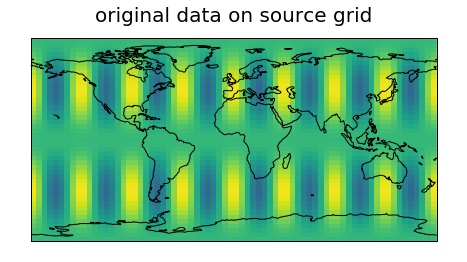

In [4]:
def plot_datafield(ax, ds, data):
    ax.pcolormesh(ds['lon_b'], ds['lat_b'], data,
                  vmin=0, vmax=3)
    ax.coastlines()

fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())
plot_datafield(ax, ds_in, ds_in['data'])
ax.set_title('original data on source grid', fontsize=20)

### Create destination grid

In [5]:
# Regional grid over North America. 1 degree in lat and lon.
ds_out = xe.grid_2d(-170, -50, 1,
                    10, 80, 1)
ds_out

<xarray.Dataset>
Dimensions:  (x: 120, x_b: 121, y: 70, y_b: 71)
Coordinates:
    lon      (y, x) float64 -169.5 -168.5 -167.5 -166.5 -165.5 -164.5 -163.5 ...
    lat      (y, x) float64 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 ...
    lon_b    (y_b, x_b) int64 -170 -169 -168 -167 -166 -165 -164 -163 -162 ...
    lat_b    (y_b, x_b) int64 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

### Regrid from source grid to destination grid

Regridding is straighforward as long as grid information is available. Just pass input grid, output grid and input data to xe.regrid( ). 

We need to pass ds_in twice because the cell bounds are dropped when converting DataSet to DataArray.

In [6]:
dr_out = xe.regrid(ds_in, ds_out, ds_in['data'])
dr_out

<xarray.DataArray 'data' (y: 70, x: 120)>
array([[ 2.012621,  1.994884,  1.977099, ...,  2.065942,  2.077464,  2.088999],
       [ 2.014763,  1.994016,  1.973215, ...,  2.077123,  2.090606,  2.104101],
       [ 2.01721 ,  1.993023,  1.968767, ...,  2.089932,  2.105634,  2.121356],
       ..., 
       [ 2.017436,  1.992939,  1.968463, ...,  2.090807,  2.1069  ,  2.122947],
       [ 2.014956,  1.993944,  1.972951, ...,  2.077884,  2.091694,  2.105463],
       [ 2.012476,  1.994948,  1.977441, ...,  2.064956,  2.076483,  2.087973]])
Coordinates:
    lon      (y, x) float64 -169.5 -168.5 -167.5 -166.5 -165.5 -164.5 -163.5 ...
    lat      (y, x) float64 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 ...
Dimensions without coordinates: y, x

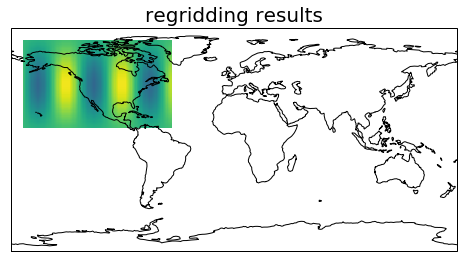

In [7]:
fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())
plot_datafield(ax, ds_out, dr_out)
ax.set_title('regridding results', fontsize=20)
ax.set_global()

### Choose regridding algoritms

ESMF supports 5 different algorithms, as shown below.

bilinear conservative patch nearest_s2d nearest_d2s 

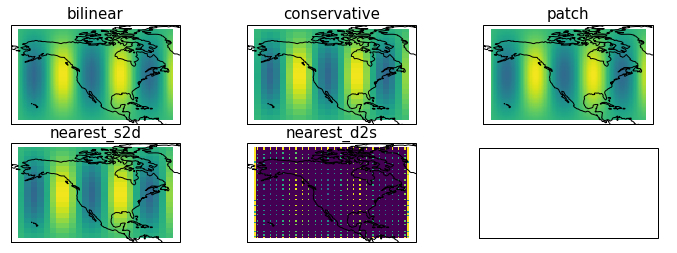

In [8]:
method_list = ['bilinear', 'conservative', 'patch', 'nearest_s2d', 'nearest_d2s']

fig, axes = plt.subplots(2,3,figsize=[12,4],
                         subplot_kw=dict(projection=ccrs.PlateCarree()))

for i, method in enumerate(method_list):
    print(method, end=' ')
    ax = axes.flatten()[i]
    dr_out = xe.regrid(ds_in, ds_out, ds_in['data'], method=method)
    plot_datafield(ax, ds_out, dr_out)
    ax.set_title(method, fontsize=15)

- When downscaling from coarse grid to fine grid, **bilinear** regridding will give smooth results, but **first-order conservative** regridding will preserve the coarse grid structure. However, when regridding from find grid to coarse grid (upscaling, different from this example), **conservative** is usually a better option as it takes into account all grid boxes and conserves total mass.

- **patch** is ESMF's unique method, giving smoother results than bilinear, but much slower.

- **"nearest source to destination"** fills the entire destination grid based on the distance to source grid points. 

- **"nearest destination to source"** maps each source gird point to only one destination point, so some points in the destination will be unmapped (return zero values). When regridding from find grid to coarse grid, a single destination grid point might receive data from multiple source grid points. This means nearest_d2s is (very) non-monotonic.

## Regrid higher-dimensional data

### Make a fake 4D data

In [9]:
Nlat, Nlon = ds_in['lon'].shape
Ntime, Nlev = 3, 10

# a boring data field, only increases linearly with level
data = np.ones([Ntime, Nlev, Nlat, Nlon]) * np.arange(Nlev).reshape(1, Nlev, 1, 1)

ds_in['data3D'] = (('time', 'lev', 'y', 'x',), data)
ds_in.coords['time'] = pd.date_range('2014-09-06', periods=Ntime)
ds_in.coords['lev'] = np.linspace(100, 1000, Nlev)
ds_in

<xarray.Dataset>
Dimensions:  (lev: 10, time: 3, x: 72, x_b: 73, y: 45, y_b: 46)
Coordinates:
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 ...
    lat      (y, x) float64 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 ...
    lon_b    (y_b, x_b) int64 -180 -175 -170 -165 -160 -155 -150 -145 -140 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
  * time     (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
  * lev      (lev) float64 100.0 200.0 300.0 400.0 500.0 600.0 700.0 800.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (y, x) float64 2.005 2.002 1.999 1.996 1.995 1.996 1.999 2.002 ...
    data3D   (time, lev, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

### Perform regridding

xESMF (through ESMPy) knows how to broadcast the regridding operation across additional dimensions.

(Under the hood, there are a lot of dirty opertions that rearrange the dimension order.)

In [10]:
dr3D_out = xe.regrid(ds_in, ds_out, ds_in['data3D'], verbose=True)

input grid dimensions: ['y', 'x']
input data dimensions: ['time', 'lev', 'y', 'x']
additional dimensions: ['time', 'lev']
To match ESMPy API, rearrange input data dimensions to: ('y', 'x', 'time', 'lev')
Passing cell corners. Conservative regridding is available.
Passing cell corners. Conservative regridding is available.
output dimensions from ESMPy: ('y', 'x', 'time', 'lev')
rearrange output dimensions to: ('time', 'lev', 'y', 'x')


### Check results

Coordinate information along extra dimensions (time and lev) is preserved.

In [11]:
dr3D_out.dims, dr3D_out.coords

(('time', 'lev', 'y', 'x'), Coordinates:
     lon      (y, x) float64 -169.5 -168.5 -167.5 -166.5 -165.5 -164.5 -163.5 ...
     lat      (y, x) float64 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 ...
   * time     (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
   * lev      (lev) float64 100.0 200.0 300.0 400.0 500.0 600.0 700.0 800.0 ...)

Make sure additional dimensions are broadcasted correctly.

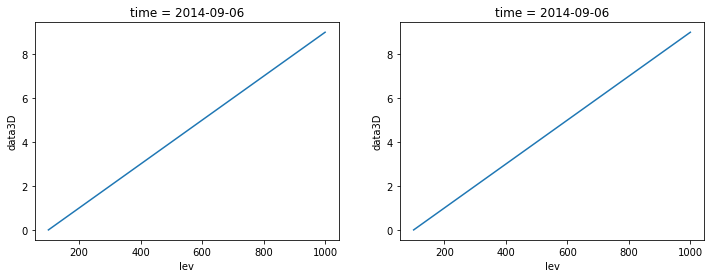

In [12]:
plt.figure(figsize=[12,4])
plt.subplot(121)
ds_in['data3D'].isel(time=0).mean(dim=['x','y']).plot()
plt.subplot(122)
dr3D_out.isel(time=0).mean(dim=['x','y']).plot()